The first step is to import the required libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
from PIL import Image

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

The next step is to prepare the dataset for use. We first get the list of filenames for the train and validation datasets.

In [2]:
img_dir = './images'
datasets = os.listdir(img_dir)
emotions = os.listdir(f'{img_dir}/train')

The function `get_filenames` creates a Pandas DataFrame containing the file path, label, and emotion index for each image in the given dataset. Two DataFrames are created for the training and validation sets.

In [3]:
def get_filenames(dataset):
    data = []
    for i, e in enumerate(emotions):
        for file in os.listdir(f'{img_dir}/{dataset}/{e}'):
            data.append({ "path": f'{img_dir}/{dataset}/{e}/{file}', "label": e, "emotion": i})
    return pd.DataFrame(data)
df = get_filenames('train').sample(frac=1)
test_df = get_filenames('validation').sample(frac=1)



The training DataFrame is split into training and validation DataFrames.

In [ ]:
validation_df = df.sample(frac=0.2)
train_df = df.drop(validation_df.index)

A sample of images from the training set is displayed for visual inspection.

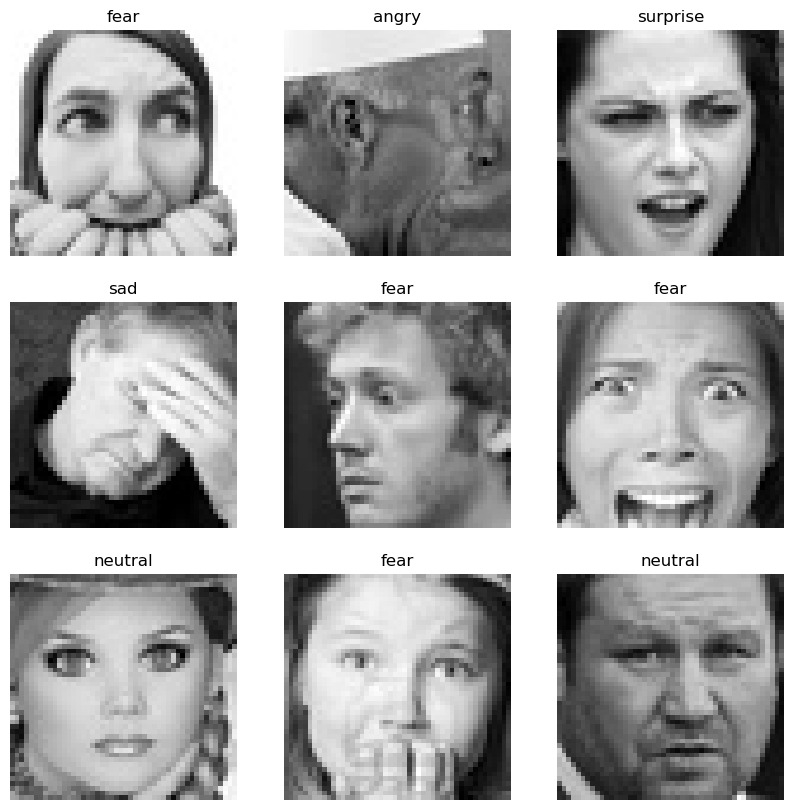

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(train_df.iloc[i]['path']), cmap="gray")
    plt.title(train_df.iloc[i]['label'])
    plt.axis("off")

The `load_image` function reads the image file at the given path, resizes it to 48x48 pixels, converts it to a NumPy array, and adds an additional dimension for the grayscale channel.

In [5]:
def load_image(img_path):
    image = Image.open(img_path)
    image = np.asarray(image.resize((48,48)))
    image = np.expand_dims(image, axis=-1)
    return image

The `batch_generator` function generates batches of images and labels from the given DataFrame. It shuffles the data and yields batches of the specified size until it has gone through the entire DataFrame. If loop is set to True, it resets the generator and allows the same generator to be used for multiple epochs.

In [6]:
def batch_generator(data, batch_size=32, loop=True):
    while True:
        df = data.sample(frac=1)
        start = 0
        while start < len(df):
            df_batch = df[start: start + batch_size]
            images = np.stack(df_batch['path'].apply(load_image).values)
            images = tf.convert_to_tensor(images, dtype=tf.float32)
            labels = df_batch['emotion'].values
            yield images, labels
            start += batch_size
        if not loop:
            break


This model is a Convolutional Neural Network (CNN) with three convolutional layers followed by two fully connected (Dense) layers. The input shape of the model is (48, 48, 1), which corresponds to grayscale images with a size of 48x48 pixels.

The first convolutional layer has 32 filters of size (3, 3) and uses the ReLU activation function. The output is then max-pooled with a pooling window of size (2, 2).

The second convolutional layer has 64 filters of size (3, 3) and uses the ReLU activation function. The output is again max-pooled with a pooling window of size (2, 2).

The third convolutional layer has 64 filters of size (3, 3) and uses the ReLU activation function.

The output from the convolutional layers is flattened into a 1-dimensional array and fed into a fully connected layer with 64 neurons, which uses the ReLU activation function.

Finally, there is a fully connected output layer with 7 neurons, which corresponds to the number of classes (emotions) being predicted. No activation function is specified for this output layer, which means that the output values will be logits (raw predictions) that can be passed through a softmax function to obtain class probabilities.


In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(7))


Next the model is trained. We use early stopping, which is a technique used to prevent overfitting of the model by monitoring the validation loss and stopping the training process when the validation loss stops decreasing. It is specified with a patience parameter which is the number of epochs with no improvement after which training will be stopped. The restore_best_weights parameter is set to True to restore the weights of the model corresponding to the epoch with the lowest validation loss.

The code then compiles the Keras model with the specified optimizer, loss function, and metrics. The optimizer used here is Adam and the loss function used is sparse categorical cross-entropy.

The model is then trained on the training data using the fit() method of the Keras model. The training is done for 25 epochs with a batch size of 64. The validation data is also used during training to monitor the model's performance on data it has not seen during training. The early_stop callback function is passed to the model's fit method to prevent overfitting.

After the model is trained, it is evaluated on the test data using the evaluate() method of the Keras model. The test loss and accuracy are then printed to the console.


In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    batch_generator(train_df, 64),
    steps_per_epoch=len(train_df) // 64,
    epochs=25,
    validation_data=batch_generator(validation_df, 64),
    validation_steps=len(validation_df) // 64,
    callbacks=[early_stop],
)

test_loss, test_acc = model.evaluate(batch_generator(test_df, 1024, False), verbose=2)
print(f"Test accuracy: {test_acc}")

Epoch 1/25
360/360 [==============================] - 36s 90ms/step - loss: 2.0807 - accuracy: 0.2929 - val_loss: 1.6312 - val_accuracy: 0.3714
Epoch 2/25
360/360 [==============================] - 24s 67ms/step - loss: 1.5651 - accuracy: 0.3966 - val_loss: 1.5675 - val_accuracy: 0.3970
Epoch 3/25
360/360 [==============================] - 30s 84ms/step - loss: 1.4607 - accuracy: 0.4390 - val_loss: 1.4654 - val_accuracy: 0.4366
Epoch 4/25
360/360 [==============================] - 26s 72ms/step - loss: 1.3787 - accuracy: 0.4732 - val_loss: 1.4324 - val_accuracy: 0.4528
Epoch 5/25
360/360 [==============================] - 26s 71ms/step - loss: 1.3074 - accuracy: 0.5052 - val_loss: 1.3743 - val_accuracy: 0.4741
Epoch 6/25
360/360 [==============================] - 25s 70ms/step - loss: 1.2326 - accuracy: 0.5342 - val_loss: 1.3813 - val_accuracy: 0.4814
Epoch 7/25
360/360 [==============================] - 24s 68ms/step - loss: 1.1439 - accuracy: 0.5684 - val_loss: 1.3892 - val_accuracy:

We then plot the training accuracy (accuracy) and validation accuracy (val_accuracy) on the y-axis, and the epoch number on the x-axis to visualize the progress of the training.

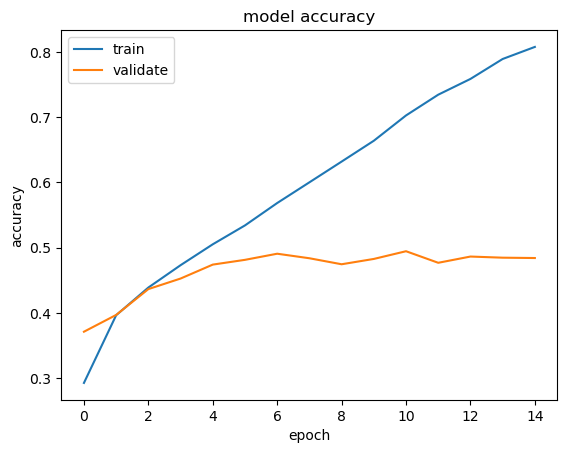

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

Both the training and validation accuracy increase for the first few epochs, but then the validation accuracy trails off. This observation suggests that the model is overfitting the training data. Overfitting occurs when the model becomes too complex and starts to memorize the training data instead of learning to generalize well to new, unseen data. As a result, the model may perform well on the training data but poorly on the validation and test data.
To address this issue, we apply two techniques:
1. Data augmentation - a technique used to artificially expand a dataset by creating modified versions of existing images. The modified images retain the same label as the original, but have been modified in some way, such as by rotation, scaling, or flipping. Data augmentation can be used to improve the performance of machine learning models by exposing them to a greater variety of training data, which can help to prevent overfitting and improve generalization. 
2. Dropout - a regularization technique commonly used in neural networks to prevent overfitting. It works by randomly setting some of the output values of a layer to zero during training, which causes the network to learn more robust features that are not overly dependent on the input values. By randomly dropping out some neurons during training, the network is forced to learn multiple independent representations of the same data, which helps to reduce the network's sensitivity to specific inputs and increases its generalization ability.



Here, we use ImageDataGenerator to create a generator for the images. The rescale parameter is used to scale the pixel values between 0 and 1. The flow_from_directory method is used to generate batches of data from the directory data. The target_size parameter is used to resize the images to 224x224 pixels. The batch_size parameter specifies the size of the batches. The class_mode parameter is set to categorical to indicate that the labels are categorical. When using the ImageDataGenerator class, each image is randomly transformed before being fed to the model during training, which creates new examples to train on. The flow_from_directory method is used to generate batches of images from a directory and automatically infer the labels from the directory structure.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rescale=1.0 / 255, 
    rotation_range=30, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)


train_generator = datagen.flow_from_directory(
    f"{img_dir}/train",
    target_size=(48, 48),
    batch_size=64,
    class_mode="categorical",
    subset="training",
)

validation_generator = datagen.flow_from_directory(
    f"{img_dir}/validation",
    target_size=(48, 48),
    batch_size=64,
    class_mode="categorical",
    subset="validation",
)

test_generator = ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(
    f"{img_dir}/validation",
    target_size=(48, 48),
    batch_size=1024,
    class_mode="categorical",
)


Found 23060 images belonging to 7 classes.
Found 1411 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


The model is redefined to include Dropout layers

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.Dropout(0.25))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(7))

In [16]:

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stop],
)

test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"Test accuracy: {test_acc}")


Epoch 1/25


2023-03-27 17:14:27.005565: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


361/361 [==============================] - 46s 122ms/step - loss: 1.7970 - accuracy: 0.2546 - val_loss: 1.7613 - val_accuracy: 0.2934
Epoch 2/25
361/361 [==============================] - 44s 122ms/step - loss: 1.7432 - accuracy: 0.2883 - val_loss: 1.7328 - val_accuracy: 0.3040
Epoch 3/25
361/361 [==============================] - 44s 121ms/step - loss: 1.7034 - accuracy: 0.3101 - val_loss: 1.7013 - val_accuracy: 0.3189
Epoch 4/25
361/361 [==============================] - 43s 120ms/step - loss: 1.6537 - accuracy: 0.3411 - val_loss: 1.6368 - val_accuracy: 0.3629
Epoch 5/25
361/361 [==============================] - 44s 121ms/step - loss: 1.6122 - accuracy: 0.3636 - val_loss: 1.6053 - val_accuracy: 0.3749
Epoch 6/25
361/361 [==============================] - 43s 120ms/step - loss: 1.5756 - accuracy: 0.3809 - val_loss: 1.5470 - val_accuracy: 0.4132
Epoch 7/25
361/361 [==============================] - 43s 119ms/step - loss: 1.5477 - accuracy: 0.3947 - val_loss: 1.5130 - val_accuracy: 0.4

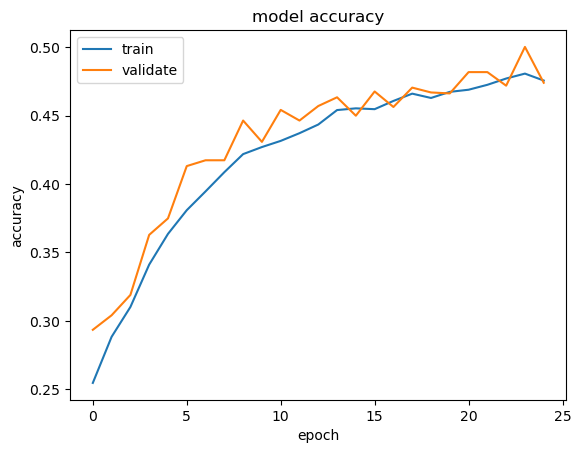

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

After the model improvements, the train accuracy does not improve significantly while the validation accuracy remains close to the train accuracy. This is an indication of good generalization of the model. This means that the model is able to learn from the training data and generalize well to unseen data. Higher accuracy may be achieved by training for more epochs.

Another approach at improving the model is to use a pretrained model. We use the VGG16 pretrained model. VGG-16 is a popular convolutional neural network architecture that has been pretrained on large-scale image classification tasks such as the ImageNet dataset. Using a pretrained VGG-16 model can provide several benefits, including:
1. Transfer learning: Pretrained models can be fine-tuned on a new dataset with fewer training examples, which can lead to better performance than training a new model from scratch.
2. Feature extraction: The convolutional layers of a pretrained VGG-16 model can be used to extract features from images, which can then be used as inputs to a new model for a specific task.

First we load the pre-trained VGG16 model with the `imagenet` weights. We do not include the fully connected layers at the output.

Next we freeze weights for the convolutional base

Next, we create a model with the pretrained VGG16 model convolutional base and additional fully connected layers 

In [18]:
from tensorflow.keras.applications import VGG16


# Load the pre-trained VGG16 model
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(48, 48, 3))

# Freeze the weights of the convolutional base
conv_base.trainable = False

# Create a new model that includes the VGG16 convolutional base
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 4096)              2101248   
                                                                 
 dense_9 (Dense)             (None, 1024)              4195328   
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 7)                 7175      
                                                                 
Total params: 21,018,439
Trainable params: 6,303,751
N

In [19]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stop],
)

test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"Test accuracy: {test_acc}")

Epoch 1/25
361/361 [==============================] - 47s 124ms/step - loss: 1.7104 - accuracy: 0.3161 - val_loss: 1.6659 - val_accuracy: 0.3359
Epoch 2/25
361/361 [==============================] - 44s 122ms/step - loss: 1.6472 - accuracy: 0.3514 - val_loss: 1.6344 - val_accuracy: 0.3664
Epoch 3/25
361/361 [==============================] - 45s 126ms/step - loss: 1.6290 - accuracy: 0.3523 - val_loss: 1.6539 - val_accuracy: 0.3466
Epoch 4/25
361/361 [==============================] - 45s 125ms/step - loss: 1.6152 - accuracy: 0.3645 - val_loss: 1.6188 - val_accuracy: 0.3692
Epoch 5/25
361/361 [==============================] - 45s 124ms/step - loss: 1.6041 - accuracy: 0.3692 - val_loss: 1.6165 - val_accuracy: 0.3728
Epoch 6/25
361/361 [==============================] - 45s 125ms/step - loss: 1.5898 - accuracy: 0.3762 - val_loss: 1.6279 - val_accuracy: 0.3707
Epoch 7/25
361/361 [==============================] - 45s 126ms/step - loss: 1.5850 - accuracy: 0.3775 - val_loss: 1.6111 - val_ac

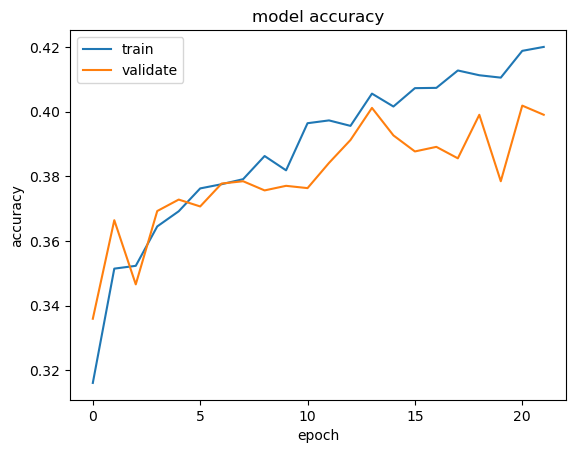

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

The training and validation accuracies go hand in hand for this model as well.

The accuracy on the training set is 41.37%.

Increasing the number of epochs and also increasing the amount of training data would result in a higher accuracy.